# Segmentation of Indian Traffic

In [1]:
!pip install tensorflow==2.2.0
!pip install keras==2.3.1

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 454 kB 51.1 MB/s 
     |████████████████████████████████| 3.0 MB 36.2 MB/s 
     |████████████████████████████████| 2.9 MB 39.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalli

In [ ]:
try:     
  import tensorflow.compat.v1 as tf     
  tf.disable_v2_behavior()     
  print('v1 behaviour!') 
except ImportError:     
  import tensorflow as tf     
  print('Entered in the exception')

tf.__version__

v1 behaviour!


'2.7.0'

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib
import imgaug.augmenters as iaa
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split

In [ ]:
tf.__version__

'2.7.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    
    '''initilaizing variables for image and json path'''
    images_path = []
    json_path = []
    '''Path to images'''
    path_i = os.path.join(root_dir,'images')
    '''path to mask'''
    path_j = os.path.join(root_dir,'mask')
    '''total items in images folder'''
    total_dir = os.listdir(path_i)
    '''Getting suffix used in json names'''
    json_suffix = '_gtFine_polygons.json'
    '''Iterating over each folder in images'''
    for folder in tqdm(total_dir):
        '''Getting the path to the folder'''
        path_1 = os.path.join(path_i,folder)
        '''getting the images in the folder'''
        images = os.listdir(path_1)
        '''Iterating over each image'''
        for image in images:
            '''getting the frame id from the image name'''
            frame_name = image.split('_')[0]
            '''appending the image path'''
            images_path.append(os.path.join(path_1,image))
            '''Creating corresponding mask path and appending it'''
            json_path.append(os.path.join(path_j,folder,frame_name+json_suffix))
    
                    
    data_df = pd.DataFrame()
    data_df['image'] = images_path
    data_df['json'] = json_path
    return data_df


In [ ]:
root_dir = os.path.join(os.getcwd(),'data')
data_df = return_file_names_df('data')
data_df.head()

100%|██████████| 143/143 [00:00<00:00, 5651.96it/s]


,image,json
0,data/images/231/frame0959_leftImg8bit.jpg,data/mask/231/frame0959_gtFine_polygons.json
1,data/images/231/frame3047_leftImg8bit.jpg,data/mask/231/frame3047_gtFine_polygons.json
2,data/images/231/frame1967_leftImg8bit.jpg,data/mask/231/frame1967_gtFine_polygons.json
3,data/images/231/frame0007_leftImg8bit.jpg,data/mask/231/frame0007_gtFine_polygons.json
4,data/images/231/frame3407_leftImg8bit.jpg,data/mask/231/frame3407_gtFine_polygons.json


In [ ]:
for i in np.random.choice(range(0,len(data_df)),7):
    print(data_df.iloc[i][0])
    print(data_df.iloc[i][1])
    print('\n')

data/images/306/frame5181_leftImg8bit.jpg
data/mask/306/frame5181_gtFine_polygons.json


data/images/377/frame24335_leftImg8bit.jpg
data/mask/377/frame24335_gtFine_polygons.json


data/images/350/frame12444_leftImg8bit.jpg
data/mask/350/frame12444_gtFine_polygons.json


data/images/277/frame18417_leftImg8bit.jpg
data/mask/277/frame18417_gtFine_polygons.json


data/images/296/frame3783_leftImg8bit.jpg
data/mask/296/frame3783_gtFine_polygons.json


data/images/312/frame44878_leftImg8bit.jpg
data/mask/312/frame44878_gtFine_polygons.json


data/images/375/frame7499_leftImg8bit.jpg
data/mask/375/frame7499_gtFine_polygons.json




> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    root_dir = os.getcwd()
    unique_labels = set()
    '''iterating over each json file'''
    for path in tqdm(data_df['json'].values):
        '''getting path till json file'''
        json_path = os.path.join(root_dir,path)
        file = open(json_path)
        '''loading data in json file'''
        json_data = json.load(file)
        '''iterating over all objects in json file'''
        for i in json_data['objects']:
            '''Getting label of the object'''
            label = i['label']
            '''Adding to set'''
            unique_labels.add(label)
    return list(unique_labels)

unique_labels = return_unique_labels(data_df)
unique_labels

100%|██████████| 4008/4008 [00:34<00:00, 117.46it/s]


['bicycle',
 'person',
 'ego vehicle',
 'motorcycle',
 'parking',
 'obs-str-bar-fallback',
 'out of roi',
 'vegetation',
 'fence',
 'guard rail',
 'pole',
 'trailer',
 'bus',
 'vehicle fallback',
 'rectification border',
 'rail track',
 'truck',
 'billboard',
 'road',
 'traffic light',
 'car',
 'traffic sign',
 'sky',
 'non-drivable fallback',
 'sidewalk',
 'animal',
 'autorickshaw',
 'building',
 'bridge',
 'caravan',
 'polegroup',
 'fallback background',
 'unlabeled',
 'rider',
 'tunnel',
 'train',
 'ground',
 'drivable fallback',
 'wall',
 'curb']

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [12]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label = []
    vertexlist = []
    f = open(file)
    '''getting data from json file'''
    data = json.load(f)
    '''Iteratin gover all objects in file'''
    for obj in data['objects']:
        '''Getting label of the object and adding in labels'''
        label.append(obj['label'])
        '''Converting polygin data into tuple'''
        polygon_tup = list(map(lambda x: tuple(x),obj['polygon']))
        '''Adding to vertexlist'''
        vertexlist.append(polygon_tup)
    '''Getting image height and width'''
    h = data['imgHeight']
    w = data['imgWidth']
    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

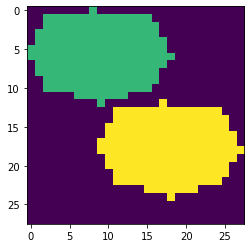

In [14]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
# print(data_df.json.values[170])
# w, h, labels, vertexlist = get_poly(data_df.json.values[170])
# print(len(vertexlist))
# list(filter(lambda x: len(x) != 2,vertexlist[24]))
# for i in vertexlist:
#     print(i)
#     print(list(filter(lambda x: len(x) != 2,i)))
#     print('\n')
os.getcwd()
!rm -r '/content/data/output'

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_path
    if(not os.path.exists(os.path.join(os.getcwd(),'data','output'))):
      os.mkdir(os.path.join(os.getcwd(),'data','output'))
    mask_save_path = os.path.join(os.getcwd(),'data','output')
    mask_suffix = '_gtFine_polygons.png'
    mask_paths = []
    for index,json_file in enumerate(tqdm(data_df.json.values)):
        scene = json_file.split('/')[2]
        frame = json_file.split('/')[3].split('_')[0]
        path = os.path.join(os.getcwd(),json_file)
        w, h, labels, vertexlist = get_poly(path)
        img = Image.new('RGB',(w,h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i]) >= 2):
#                 if(index == 170):
#                     print(vertexlist[i],labels[i])
#                     print('\n')
                img1.polygon(vertexlist[i],fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        if(os.path.exists(os.path.join(mask_save_path,scene))):
            im.save(os.path.join(mask_save_path,scene,frame+mask_suffix))
        else:
            os.mkdir(os.path.join(mask_save_path,scene))
            im.save(os.path.join(mask_save_path,scene,frame+mask_suffix))
        mask_paths.append(os.path.join('data','output',scene,frame+mask_suffix))
    data_df['mask'] = mask_paths
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:41<00:00, 14.26it/s]


,image,json,mask
0,data/images/231/frame0959_leftImg8bit.jpg,data/mask/231/frame0959_gtFine_polygons.json,data/output/231/frame0959_gtFine_polygons.png
1,data/images/231/frame3047_leftImg8bit.jpg,data/mask/231/frame3047_gtFine_polygons.json,data/output/231/frame3047_gtFine_polygons.png
2,data/images/231/frame1967_leftImg8bit.jpg,data/mask/231/frame1967_gtFine_polygons.json,data/output/231/frame1967_gtFine_polygons.png
3,data/images/231/frame0007_leftImg8bit.jpg,data/mask/231/frame0007_gtFine_polygons.json,data/output/231/frame0007_gtFine_polygons.png
4,data/images/231/frame3407_leftImg8bit.jpg,data/mask/231/frame3407_gtFine_polygons.json,data/output/231/frame3407_gtFine_polygons.png


In [ ]:
data_df.head()

,image,json,mask
0,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
1,data/images/201/frame3749_leftImg8bit.jpg,data/mask/201/frame3749_gtFine_polygons.json,data/output/201/frame3749_gtFine_polygons.png
2,data/images/201/frame2819_leftImg8bit.jpg,data/mask/201/frame2819_gtFine_polygons.json,data/output/201/frame2819_gtFine_polygons.png
3,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
4,data/images/201/frame2519_leftImg8bit.jpg,data/mask/201/frame2519_gtFine_polygons.json,data/output/201/frame2519_gtFine_polygons.png


In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4008/4008 [04:16<00:00, 15.61it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)
data_df = pd.read_csv('preprocessed_data.csv')
print(data_df.shape)
data_df.head()

(4008, 3)


,image,json,mask
0,data/images/231/frame0959_leftImg8bit.jpg,data/mask/231/frame0959_gtFine_polygons.json,data/output/231/frame0959_gtFine_polygons.png
1,data/images/231/frame3047_leftImg8bit.jpg,data/mask/231/frame3047_gtFine_polygons.json,data/output/231/frame3047_gtFine_polygons.png
2,data/images/231/frame1967_leftImg8bit.jpg,data/mask/231/frame1967_gtFine_polygons.json,data/output/231/frame1967_gtFine_polygons.png
3,data/images/231/frame0007_leftImg8bit.jpg,data/mask/231/frame0007_gtFine_polygons.json,data/output/231/frame0007_gtFine_polygons.png
4,data/images/231/frame3407_leftImg8bit.jpg,data/mask/231/frame3407_gtFine_polygons.json,data/output/231/frame3407_gtFine_polygons.png


# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

DICE LOSS FORMULATION: 1- 2*tp/(tp + fp + fn) or intersection/uniion.
RANGE: 0 to 1
INTERPERTATION: Segmentation tries to label each pixel to a class. here our class are different objects in the image that we want to segment. So this can be thought of as a multiclass classification problem for pixels. Now we know we can calculate our true positives, false positives, false negatives . dice loss is calculated using these values. Now when we will label our pixels correctly our tp count would increase and hence loss will be close to 0.

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [18]:
x_train,x_test = train_test_split(data_df,test_size=0.11,random_state=42)
print('X_train shape: ',x_train.shape)
print('x_test shape: ',x_test.shape)

X_train shape:  (3567, 3)
x_test shape:  (441, 3)


In [ ]:
d1,d2 = train_test_split(data_df,test_size=0.30,random_state=42)
print('X_train_exp shape: ',d1.shape)
print('x_test_exp shape: ',d2.shape)

X_train_exp shape:  (2805, 3)
x_test_exp shape:  (1203, 3)


In [ ]:
x_train_exp,x_test_exp = train_test_split(d2,test_size=0.10,random_state=42)
print('X_train_exp shape: ',x_train_exp.shape)
print('x_test_exp shape: ',x_test_exp.shape)

X_train_exp shape:  (1082, 3)
x_test_exp shape:  (121, 3)


In [21]:
!pip install segmentation_models

In [23]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [ ]:
resnet_model = Unet('resnet34', encoder_weights='imagenet', classes=21 , activation='softmax', input_shape=(256,256,3))

85524480/85521592 [==============================] - 6s 0us/step


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [19]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [20]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/10
    return mask

In [ ]:
{'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

{'animal': 50,
 'autorickshaw': 80,
 'bicycle': 70,
 'billboard': 120,
 'bridge': 140,
 'building': 140,
 'bus': 90,
 'car': 80,
 'caravan': 90,
 'curb': 100,
 'drivable fallback': 20,
 'ego vehicle': 170,
 'fallback background': 160,
 'fence': 110,
 'ground': 180,
 'guard rail': 110,
 'motorcycle': 70,
 'non-drivable fallback': 40,
 'obs-str-bar-fallback': 130,
 'out of roi': 0,
 'parking': 20,
 'person': 50,
 'pole': 130,
 'polegroup': 130,
 'rail track': 40,
 'rectification border': 190,
 'rider': 60,
 'road': 10,
 'sidewalk': 30,
 'sky': 160,
 'traffic light': 120,
 'traffic sign': 120,
 'trailer': 90,
 'train': 200,
 'truck': 90,
 'tunnel': 140,
 'unlabeled': 0,
 'vegetation': 150,
 'vehicle fallback': 90,
 'wall': 100}

In [ ]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, data_df, classes,width, height,augment_flag):
        
        self.w = width
        self.h = height
        self.data_df = data_df
        self.augment_flag = augment_flag
        # the paths of images
        #self.images_fps   = [os.path.join(images_dir, image_id+'.jpg') for image_id in self.ids]
        self.images_fps = self.data_df['image'].values
        # the paths of segmentation images
        #self.masks_fps    = [os.path.join(images_dir, image_id+".mask.jpg") for image_id in self.ids]
        self.masks_fps = self.data_df['mask'].values
        # giving labels for each class
        self.class_values = np.unique([self.CLASSES[cls.lower()]//10 for cls in classes])
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image.astype('float')
        

        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_AREA)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        image_mask = normalize_image(mask)
        
        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        #print(image_mask.shape)
        #print(image.shape)
        if(self.augment_flag):
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.data_df)
    

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
optim = tf.keras.optimizers.Adam()

focal_loss = sm.losses.cce_dice_loss

model.compile(optim, focal_loss, metrics=[iou_score])

NameError: ignored

In [ ]:
import joblib
train_dataset = Dataset(x_train, CLASSES,256,256,True)
train_dataloader = Dataloder(train_dataset, batch_size=2, shuffle=True)

In [ ]:
# Dataset for train images
width = 256
height = 256
CLASSES = unique_labels
train_dataset = Dataset(x_train, CLASSES,width,height,True)
test_dataset  = Dataset(x_test, CLASSES,width,height,False)

BATCH_SIZE=32
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#print(train_dataloader[0])
print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, width, height, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, width, height, 21)

# define callbacks for learning rate scheduling and best checkpoints saving
save_path = os.path.join(os.getcwd(),'drive','MyDrive','27_best_segmentation_model.h5')
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(save_path, save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.0001,patience=3),
]


(32, 256, 256, 3)


In [ ]:
model.load_weights(os.path.join(os.getcwd(),'drive','MyDrive','20_best_segmentation_model.h5'))

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,\
                              validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/20
106/106 [==============================] - 389s 4s/step - loss: 0.8545 - iou_score: 0.1542 - val_loss: 1.0293 - val_iou_score: 0.0702
Epoch 2/20
106/106 [==============================] - 388s 4s/step - loss: 0.7004 - iou_score: 0.2643 - val_loss: 0.8346 - val_iou_score: 0.1612
Epoch 3/20
106/106 [==============================] - 387s 4s/step - loss: 0.6417 - iou_score: 0.3101 - val_loss: 0.7836 - val_iou_score: 0.2084
Epoch 4/20
106/106 [==============================] - 386s 4s/step - loss: 0.6021 - iou_score: 0.3405 - val_loss: 0.6606 - val_iou_score: 0.2863
Epoch 5/20
106/106 [==============================] - 385s 4s/step - loss: 0.5754 - iou_score: 0.3631 - val_loss: 0.6421 - val_iou_score: 0.3003
Epoch 6/20
106/106 [==============================] - 383s 4s/step - loss: 0.5630 - iou_score: 0.3725 - val_loss: 0.6485 - val_iou_score: 0.2942
Epoch 7/20
106/106 [==============================] - 383s 4s/step - loss: 0.5396 - iou_score: 0.3945 - val_loss: 0.6174 - val_iou

In [ ]:
history1 = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,\
                              validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/20
106/106 [==============================] - 386s 4s/step - loss: 0.5340 - iou_score: 0.4001 - val_loss: 0.5910 - val_iou_score: 0.3409
Epoch 2/20
106/106 [==============================] - 382s 4s/step - loss: 0.5127 - iou_score: 0.4199 - val_loss: 0.6216 - val_iou_score: 0.3183
Epoch 3/20
106/106 [==============================] - 381s 4s/step - loss: 0.5073 - iou_score: 0.4256 - val_loss: 0.5844 - val_iou_score: 0.3507
Epoch 4/20
106/106 [==============================] - 383s 4s/step - loss: 0.4047 - iou_score: 0.5294 - val_loss: 0.4873 - val_iou_score: 0.4400
Epoch 5/20
106/106 [==============================] - 384s 4s/step - loss: 0.3302 - iou_score: 0.6032 - val_loss: 0.3976 - val_iou_score: 0.5359
Epoch 6/20
106/106 [==============================] - 384s 4s/step - loss: 0.3026 - iou_score: 0.6322 - val_loss: 0.4283 - val_iou_score: 0.5165
Epoch 7/20
106/106 [==============================] - 384s 4s/step - loss: 0.3013 - iou_score: 0.6321 - val_loss: 0.3672 - val_iou

In [ ]:
model.load_weights(os.path.join(os.getcwd(),'drive','MyDrive','27_best_segmentation_model.h5'))

In [ ]:
model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=1,\
                              validation_data=test_dataloader,callbacks=callbacks)

106/106 [==============================] - 416s 4s/step - loss: 0.2491 - iou_score: 0.6865 - val_loss: 0.3567 - val_iou_score: 0.5745


In [ ]:

def predict(model):
  '''predict the mask images from trained model'''
  #getting random 10 samples from test data
  random_samples = np.random.choice(list(range(0,len(x_test))),10)
  #iterating over samples
  for i in random_samples:
    #getting input image
    image_path = x_test.iloc[i]['image']
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #getting actual mask
    mask_path = x_test.iloc[i]['mask']
    image_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask,(256,256),interpolation=cv2.INTER_AREA)

    #getting predicted mask image
    prediction = model.predict(image[np.newaxis,:,:,:])
    prediction = tf.argmax(prediction,axis=-1)
    prediction = tf.expand_dims(prediction,axis=-1)

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(prediction[0,:,:,0])
    plt.show()

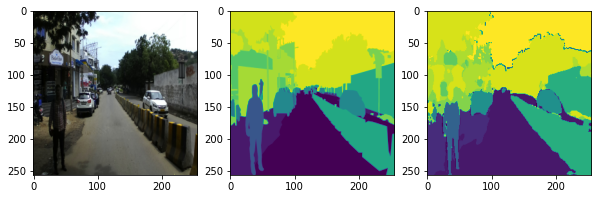

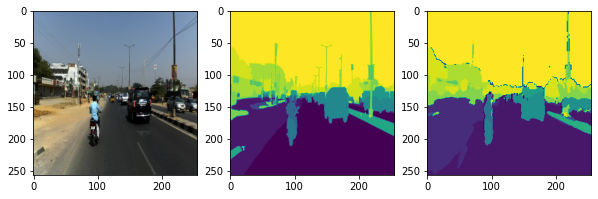

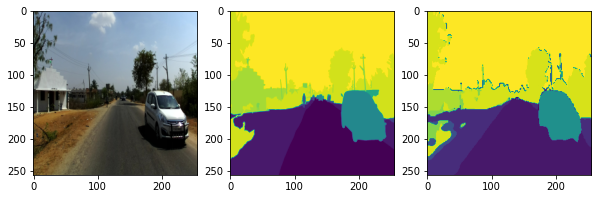

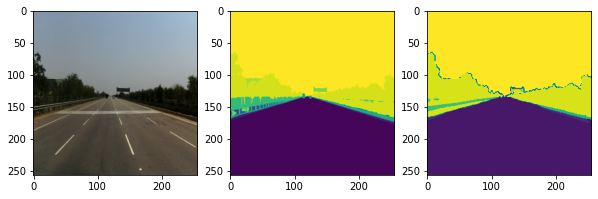

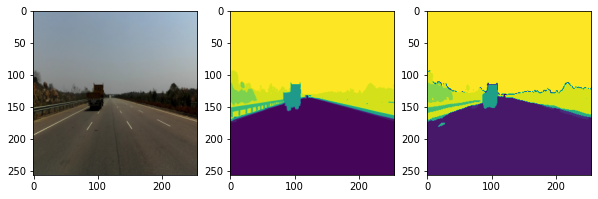

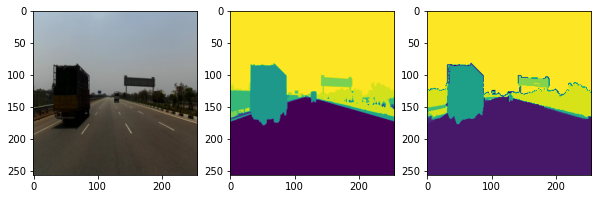

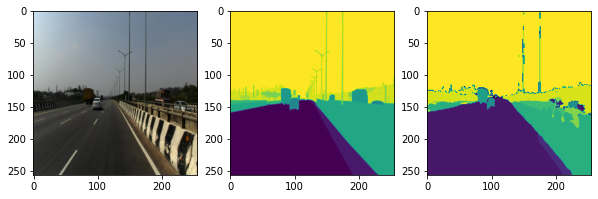

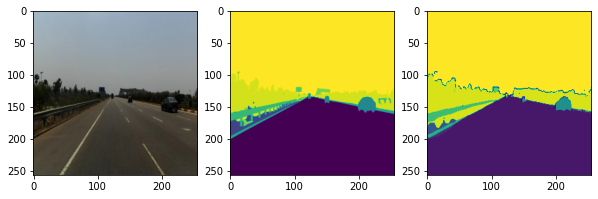

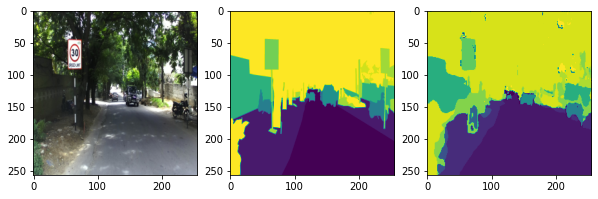

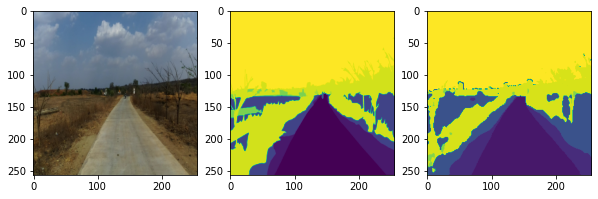

In [ ]:
predict(model)

Downloading the video data from https://youtu.be/NVMWAMqgT-Y  to apply our model 

In [ ]:
!pip install pytube

     |████████████████████████████████| 56 kB 3.0 MB/s 


In [ ]:
'''Snippet to download video'''
'''referred https://stackoverflow.com/questions/40713268/download-youtube-video-using-python-to-a-certain-directory'''

# importing the module
from pytube import YouTube

# where to save
SAVE_PATH = os.path.join(os.getcwd(),'drive','MyDrive') #to_do

# link of the video to be downloaded
link="https://youtu.be/NVMWAMqgT-Y"

YouTube(link).streams.filter(res='720p').first().download(SAVE_PATH)



'/content/drive/MyDrive/2 min of Indian driving in traffic.mp4'

In [ ]:
'''snippet to get video frame by frame'''
'''credits https://www.geeksforgeeks.org/extract-images-from-video-in-python/'''
# Importing all necessary libraries
import cv2
import os

SAVE_PATH = os.path.join(os.getcwd(),'drive','MyDrive')
# Read the video from specified path
cam = cv2.VideoCapture(os.path.join(SAVE_PATH,'2 min of Indian driving in traffic.mp4'))

try:
	
	# creating a folder named data
	if not os.path.exists('video_data'):
		os.makedirs('video_data')

# if not created then raise error
except OSError:
	print ('Error: Creating directory of video_data')

# frame
currentframe = 0

while(True):
	
	# reading from frame
    ret,frame = cam.read()

    if ret:
        # if video is still left continue creating images
        name = os.path.join(os.getcwd(),'video_data','frame' + str(currentframe) + '.jpg')
        #name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name)

        # writing the extracted images
        cv2.imwrite(name, frame)

        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
      break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()


Creating.../content/video_data/frame0.jpg
Creating.../content/video_data/frame1.jpg
Creating.../content/video_data/frame2.jpg
Creating.../content/video_data/frame3.jpg
Creating.../content/video_data/frame4.jpg
Creating.../content/video_data/frame5.jpg
Creating.../content/video_data/frame6.jpg
Creating.../content/video_data/frame7.jpg
Creating.../content/video_data/frame8.jpg
Creating.../content/video_data/frame9.jpg
Creating.../content/video_data/frame10.jpg
Creating.../content/video_data/frame11.jpg
Creating.../content/video_data/frame12.jpg
Creating.../content/video_data/frame13.jpg
Creating.../content/video_data/frame14.jpg
Creating.../content/video_data/frame15.jpg
Creating.../content/video_data/frame16.jpg
Creating.../content/video_data/frame17.jpg
Creating.../content/video_data/frame18.jpg
Creating.../content/video_data/frame19.jpg
Creating.../content/video_data/frame20.jpg
Creating.../content/video_data/frame21.jpg
Creating.../content/video_data/frame22.jpg
Creating.../content/v

In [ ]:
'''Creating and saving our masks which the model predicted for the video'''
i=0
if(not os.path.exists(os.path.join(os.getcwd(),'drive','MyDrive','mask_data'))):
  os.mkdir(os.path.join(os.getcwd(),'drive','MyDrive','mask_data'))

frames = len(os.listdir(os.path.join(os.getcwd(),'video_data')))
frames

#iterating over all the video frames
while(i!=frames):
  
  #Getting the image abd resizing it according to our input model
  image_path = os.path.join(os.getcwd(),'video_data','frame'+str(i)+'.jpg')
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  #getting the prediction mask image
  prediction = model.predict(image[np.newaxis,:,:,:])
  prediction = tf.argmax(prediction,axis=-1)
  prediction = tf.expand_dims(prediction,axis=-1)

  #saving the mask image
  plt.figure(figsize=(10,6))
  plt.subplot(132)
  plt.imshow(prediction[0,:,:,0])
  mask_path = os.path.join(os.getcwd(),'drive','MyDrive','mask_data','frame'+str(i)+'.png')
  print('Creating...',mask_path)
  plt.savefig(mask_path)
  plt.close()
  i+=1




Creating... /content/drive/MyDrive/mask_data/frame0.png
Creating... /content/drive/MyDrive/mask_data/frame1.png
Creating... /content/drive/MyDrive/mask_data/frame2.png
Creating... /content/drive/MyDrive/mask_data/frame3.png
Creating... /content/drive/MyDrive/mask_data/frame4.png
Creating... /content/drive/MyDrive/mask_data/frame5.png
Creating... /content/drive/MyDrive/mask_data/frame6.png
Creating... /content/drive/MyDrive/mask_data/frame7.png
Creating... /content/drive/MyDrive/mask_data/frame8.png
Creating... /content/drive/MyDrive/mask_data/frame9.png
Creating... /content/drive/MyDrive/mask_data/frame10.png
Creating... /content/drive/MyDrive/mask_data/frame11.png
Creating... /content/drive/MyDrive/mask_data/frame12.png
Creating... /content/drive/MyDrive/mask_data/frame13.png
Creating... /content/drive/MyDrive/mask_data/frame14.png
Creating... /content/drive/MyDrive/mask_data/frame15.png
Creating... /content/drive/MyDrive/mask_data/frame16.png
Creating... /content/drive/MyDrive/mask_d

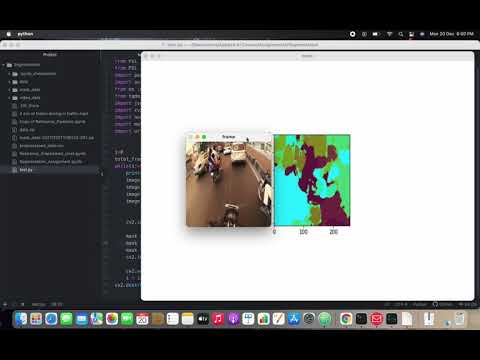

In [ ]:
''' Here is the result of segmentation .
link to the video https://www.youtube.com/watch?v=AQQVOpnYeV8'''

'''Created segmentation using the following code on local machine
make sure that you have video_data and mask_data in the folder

import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib


i=0
total_frames = len(os.listdir(os.path.join(os.getcwd(),'video_data')))
while(i!=total_frames):
    print('frame ',i)
    image_path = os.path.join(os.getcwd(),'video_data','frame'+str(i)+'.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    cv2.imshow('frame',image)

    mask = cv2.imread(os.path.join(os.getcwd(),'mask_data','frame'+str(i)+'.png'))
    mask = cv2.resize(mask,(1000,720),interpolation=cv2.INTER_AREA)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    cv2.imshow('mask',mask)

    cv2.waitKey(20)
    i = i+1
cv2.destroyAllWindows()'''

from IPython.display import YouTubeVideo
YouTubeVideo('AQQVOpnYeV8')

# Task 3: Training CANet

In [24]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.initializers import glorot_uniform
from keras.regularizers import l2
import numpy as np
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import joblib

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [25]:
class convolutional_block(tf.keras.Model):
    def __init__(self,kernel=3,  filters=[4,4,8], stride=1):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.add = Add()
        
        #first conv layer
        self.conv1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same'
                            )
        #batch norm layer
        self.BN1 = BatchNormalization(axis=3)


        #sec conv lyer
        self.conv2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same'
                            )
        self.BN2 = BatchNormalization(axis=3)

        #third conv layer
        self.conv3 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same',
                            )
        self.BN3 = BatchNormalization(axis=3)

        #fourth conv layer
        self.conv4 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same',
                           )
        #batch norm layer
        self.BN4 = BatchNormalization(axis=3)

        #activation layer
        self.activation = Activation('relu')
            
    def call(self, X):
        # write the architecutre that was mentioned above

        Y = self.conv3(X)
        Y = self.BN3(Y)
        Y = self.activation(Y)
        #Y = self.maxpool2(Y)

        #print(X.shape)
        X = self.conv1(X)
        #print(X.shape)
        X = self.BN1(X)
        X = self.activation(X)

        X = self.conv2(X)
        #print(X.shape)
        X = self.BN2(X)
        X = self.activation(X)
        #X = self.maxpool1(X)

        X = self.conv4(X)
        #print(X.shape)
        X = self.BN4(X)

        X = self.add([X,Y])
        X = self.activation(X)

        return X





In [26]:
class identity_block(tf.keras.Model):
    def __init__(self,kernel=3,  filters=[4,4,8]):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.add = Add()
        
        #first conv layer
        self.conv1 = Conv2D(self.F1,(1,1),padding='same'
                            
                            )
        #activation layer
        self.activation1 = Activation(relu)
        #batch norm layer
        self.BN1 = BatchNormalization(axis=3)

        #second conv layer
        self.conv2 = Conv2D(self.F2,(3,3),strides=(1,1),padding='same'
                            )
        #activation layer
        self.activation2 = Activation('relu')
        #batch norm layer
        self.BN2 = BatchNormalization(axis=3)



        #third conv layer
        self.conv3 = Conv2D(self.F3,(1,1),padding='same',
                            )
        #activation layer
        self.activation3 = Activation('relu')
        #batch norm layer
        self.BN3 = BatchNormalization(axis=3)


    def call(self, X):
        # write the architecutre that was mentioned above
        Y=X

        X = self.conv1(X)
        X = self.BN1(X)
        X = self.activation1(X)

        X = self.conv2(X)
        X = self.BN2(X)
        X = self.activation2(X)

       

        X = self.conv3(X)
        X = self.BN3(X)
        

        X = self.add([X,Y])
        X = self.activation3(X)

        return X



* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [27]:
class global_flow(tf.keras.Model):
    def __init__(self,name="global_flow"):
        super().__init__(name=name)
        self.globalavglayer = GlobalAveragePooling2D()
        self.BN = BatchNormalization(axis=3)
        self.activation = Activation('relu')
        
        
    def build(self, input_shape):
        
        self.conv = Conv2D(input_shape[-1],(1,1),padding='same'
                           )
        #self.conv = Conv2D(64,(1,1),padding='same')
        self.upsample = UpSampling2D((input_shape[1],input_shape[2]),interpolation='bilinear')
        #self.upsample = UpSampling2D((32,input_shape[2]),interpolation='bilinear')
    def call(self, X):
        # implement the global flow operatiom
        X = self.globalavglayer(X)
        X = tf.expand_dims(X,axis=1)
        X = tf.expand_dims(X,axis=1)
        X = self.BN(X)
        
        X = self.activation(X)
        
        X = self.conv(X)
        X = self.upsample(X)
        
        return X



In [28]:
class context_flow(tf.keras.Model):    
    def __init__(self,N=2):
        super().__init__()
        #nitializing layers used in CF
      
        self.concat = Concatenate()
        self.mult = Multiply()
        self.add = Add()
        self.avgpool = AveragePooling2D(pool_size=(2,2),strides=N)
        
        self.reluact = Activation('relu')
        
        self.sigmoidact = Activation(sigmoid)
        self.upconv = UpSampling2D((N,N),interpolation='bilinear')
        

    def build(self,X):
        INP,FLOW = X[0], X[1]
        global_output_shape = FLOW

        self.conv1 = Conv2D(global_output_shape[-1],(3,3),padding='same'
                            )
        self.conv2 = Conv2D(global_output_shape[-1],(3,3),padding='same'
                            )

        self.conv3 = Conv2D(global_output_shape[-1],(1,1),padding='same'
                            )
        self.conv4 = Conv2D(global_output_shape[-1],(1,1),padding='same'
                            )

        # self.conv1 = Conv2D(64,(3,3),strides=(1,1),padding='same')
        # self.conv2 = Conv2D(64,(3,3),strides=(1,1),padding='same')

        # self.conv3 = Conv2D(64,(1,1),strides=(1,1),padding='same',kernel_initializer='glorot_uniform'
        #                     )
        # self.conv4 = Conv2D(64,(1,1),strides=(1,1),padding='same')

    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        #implementing context fusion part
        X = self.concat([INP,FLOW])
        
        X = self.avgpool(X)
        
        X = self.conv1(X)
        
        Y = self.conv2(X)#Y has output from encoder part
        
        #implemeting context refinemnet part
        X = self.conv3(Y)
        
        X = self.reluact(X)
        
        X = self.conv4(X)
        
        X = self.sigmoidact(X)
        

        X = self.mult([Y,X])
        
        X = self.add([Y,X])
        
        X = self.upconv(X)
        
        return X



* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [29]:


class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv_1 = Conv2D(32 ,kernel_size=(3,3),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.bn =BatchNormalization()
        self.act_sigmoid= Activation('sigmoid')
        self.multiply =Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        X= self.conv_1(X)
        global_avg = self.global_avg_pool(X)
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        conv1= self.conv_2(global_avg)
        bn1= self.bn(conv1)
        Y = self.act_sigmoid(bn1)
        output = self.multiply([X, Y])
        FSM_Conv_T = self.upsample(output)

        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [30]:


class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv_1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_2  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_3  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_3  = Conv2D(32,kernel_size=(3,3),padding='same')
        self.add = Add()
        
    def call(self, X):
        # please implement the above mentioned architecture
        conv1 = self.conv_1(X)
        conv2= self.conv_2(conv1)

        # side path
        conv3 = self.conv_4(X)
        conv4 = self.conv_3(conv3)

        add1 = self.add([conv2,conv4])

        conv5 = self.conv_3(add1)

        X = self.add([conv5,add1])

        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [70]:
def create_canet(classes):
    '''This function creates the entire canet architecture using functional api'''
    w = train_dataloader[0][0].shape[1]
    h = train_dataloader[0][0].shape[2]
    channels = train_dataloader[0][0].shape[3]
    weight_decay = 0
    
    X_input = Input(shape=(w,h,channels))
    print('Input = ',X_input.shape)
    # Stage 1
    X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer='lecun_normal',
               bias_initializer='lecun_normal')(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('selu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    print('C0 shape = ',X.shape)

    '''backbone structure'''
    X = convolutional_block(
                            filters = [4,4,8],
                            #filters = [16,16,32],
                            #filters = [64,64,128],
                            #filters = [128,128,256],
                            #filters = [32,32,64],
                            stride=2)(X)
    print('C1 shape = ',X.shape)
    c1_out = identity_block(
                            filters = [4,4,8],
                            #filters = [16,16,32],
                            #filters=[64,64,128]
                            #filters = [128,128,256],
                            #filters = [32,32,64],
                            )(X)
    print('I11 shape = ',c1_out.shape)
    # c1_out = identity_block(filters=[4,4,8])(X)
    # print('I12 shape = ',c1_out.shape)

    X = convolutional_block(
                            filters = [8,8,16],
                            #filters = [32,32,64],
                            #filters = [128,128,256],
                            #filters = [256,256,512],
                            #filters = [64,64,128],
                            stride=2)(c1_out)
    print('C2 shape = ',X.shape)
    X = identity_block(
                        filters = [8,8,16],
                       #filters = [32,32,64],
                       #filters=[128,128,256]
                       #filters = [256,256,512],
                       #filters = [64,64,128],
                       )(X)
    print('I21 shape = ',X.shape)
    X = identity_block(
                        filters = [8,8,16],
                       #filters = [32,32,64],
                       #filters=[128,128,256]
                       #filters = [256,256,512],
                       #filters = [64,64,128],
                       )(X)
    print('I22 shape = ',X.shape)
    # X = identity_block(filters=[8,8,16])(X)
    # print('I23 shape = ',X.shape)

    X = convolutional_block(
                            filters = [16,16,32],
                            #filters = [64,64,128],
                            #filters = [256,256,512],
                            #filters = [512,512,1024],
                            #filters = [128,128,256],
                            stride=1)(X)
    print('C3 shape = ',X.shape)
    X = identity_block(
                       #filters = [64,64,128],
                       #filters = [16,16,32]
                       #filters=[256,256,512]
                       #filters = [512,512,1024],
                       filters = [128,128,256],
                       )(X)
    print('I31 shape = ',X.shape)
    X = identity_block(
                       #filters = [64,64,128],
                       filters = [16,16,32]
                       #filters=[256,256,512]
                       #filters = [512,512,1024],
                       #filters = [128,128,256],
                       )(X)
    print('I32 shape = ',X.shape)
    X = identity_block(
                       #filters = [64,64,128],
                       filters = [16,16,32]
                       #filters=[256,256,512]
                       #filters = [512,512,1024],
                       #filters = [128,128,256],
                       )(X)
    print('I33 shape = ',X.shape)
    # X = identity_block(filters=[16,16,32])(X)
    # print('I34 shape = ',X.shape)
    # X = identity_block(filters=[16,16,32])(X)
    # print('I35 shape = ',X.shape)

    X = convolutional_block(
                            #filters = [128,128,512],
                            filters = [32,32,64],
                           #filters = [512,512,1024],
                            #filters = [1024,1024,2048],
                            #filters = [256,256,512],
                            stride=1)(X)
    print('C4 shape = ',X.shape)
    X = identity_block(
                       #filters = [128,128,512],
                       filters = [32,32,64]
                       #filters=[512,512,1024]
                       #filters = [1024,1024,2048],
                       #filters = [256,256,512],
                       )(X)
    print('I41 shape = ',X.shape)
    X = identity_block(
                       #filters = [128,128,512],
                       filters = [32,32,64]
                       #filters=[512,512,1024]
                       #filters = [1024,1024,2048],
                       #filters = [256,256,512],
                       )(X)
    print('I42 shape = ',X.shape)
    X = identity_block(
                       #filters = [128,128,512],
                       filters = [32,32,64]
                       #filters=[512,512,1024]
                       #filters = [1024,1024,2048],
                       #filters = [256,256,512],
                       )(X)
    print('I43 shape = ',X.shape)
    X = identity_block(
                       #filters = [128,128,512],
                       filters = [32,32,64]
                       #filters=[512,512,1024]
                       #filters = [1024,1024,2048],
                       #filters = [256,256,512],
                       )(X)
    print('I44 shape = ',X.shape)


    #X = Conv2D(64, (1, 1), padding="same", kernel_initializer='he_uniform',activation='relu')(X)

    #print(X.shape)
    '''Encoder'''
    X1 = global_flow()(X)
    print('Global Flow shape = ',X1.shape)
    X2 = context_flow(2)((X,X1))
    print('CF1 shape = ',X2.shape)
    X3 = context_flow(2)((X,X2))
    print('CF2 shape = ',X3.shape)
    X4 = context_flow(2)((X,X3))
    print('CF3 shape = ',X4.shape)
    # X5 = context_flow(16)((X,X4))
    # print('CF4 shape = ',X5.shape)
    X = X1+X2+X3+X4
    print('Total sum shape',X.shape)
    X = fsm()(X)
    print('FSM Shape',X.shape)
    

    '''Decoder'''
    # c1_out = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_uniform',activation='relu')(c1_out)
    c1_out = agcn()(c1_out)
    print('AGCN Shape',c1_out.shape)
    X = Concatenate()([c1_out,X])
    print('Concatenated Shape',X.shape)
    X = Conv2D(classes,(3,3),padding='same',activation='selu',
               kernel_initializer='lecun_normal',bias_initializer='lecun_normal')(X)
    print('final Conv shape',X.shape)
    X = UpSampling2D(size=(4,4),interpolation='bilinear')(X)
    print('Upsampling shape',X.shape)
    output = Activation('softmax')(X)
    print('Final shape',output)
    

    model = Model(inputs=X_input,outputs=output)
    return model

In [71]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_220 (Activation)     (None, 256, 256, 64) 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [72]:


# Dataset for train images
width = 256
height = 256
CLASSES = unique_labels
train_dataset = Dataset(x_train, CLASSES,width,height,False)
test_dataset  = Dataset(x_test, CLASSES,width,height,False)

BATCH_SIZE=8
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#print(train_dataloader[0])
print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, width, height, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, width, height, 21)


In [74]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
i_score = sm.metrics.IOUScore(threshold=0.5)
# optim = tf.keras.optimizers.RMSprop()
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.dice_loss
#iou_score = sm.metrics.IOUScore(threshold=0.5)
model.compile(optim, focal_loss, metrics=[i_score])

In [76]:
'''with bs 8 lr 0.0001'''
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,validation_data=test_dataloader)

Epoch 1/3
445/445 [==============================] - 247s 555ms/step - loss: 0.8268 - iou_score: 0.2735 - val_loss: 0.8153 - val_iou_score: 0.2701
Epoch 2/3
445/445 [==============================] - 248s 557ms/step - loss: 0.7697 - iou_score: 0.3226 - val_loss: 0.7656 - val_iou_score: 0.3562
Epoch 3/3
445/445 [==============================] - 247s 555ms/step - loss: 0.7493 - iou_score: 0.3621 - val_loss: 0.7658 - val_iou_score: 0.3511


In [77]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,validation_data=test_dataloader,
                    callbacks=call)

Epoch 1/3
445/445 [==============================] - 245s 550ms/step - loss: 0.7336 - iou_score: 0.3647 - val_loss: 0.7447 - val_iou_score: 0.3636 - lr: 1.0000e-04
Epoch 2/3
445/445 [==============================] - 245s 551ms/step - loss: 0.7198 - iou_score: 0.3736 - val_loss: 0.7341 - val_iou_score: 0.3535 - lr: 1.0000e-04
Epoch 3/3
445/445 [==============================] - 246s 552ms/step - loss: 0.7101 - iou_score: 0.3800 - val_loss: 0.7115 - val_iou_score: 0.3753 - lr: 1.0000e-04


In [78]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,validation_data=test_dataloader,
                    callbacks=call)

Epoch 1/3
445/445 [==============================] - 247s 555ms/step - loss: 0.7012 - iou_score: 0.3777 - val_loss: 0.7102 - val_iou_score: 0.3719 - lr: 1.0000e-04
Epoch 2/3
445/445 [==============================] - 249s 559ms/step - loss: 0.6936 - iou_score: 0.3755 - val_loss: 0.6998 - val_iou_score: 0.3734 - lr: 1.0000e-04
Epoch 3/3
445/445 [==============================] - 250s 562ms/step - loss: 0.6677 - iou_score: 0.3811 - val_loss: 0.5666 - val_iou_score: 0.3717 - lr: 1.0000e-04


In [79]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,validation_data=test_dataloader,
                    callbacks=call)

Epoch 1/3
445/445 [==============================] - 246s 553ms/step - loss: 0.5398 - iou_score: 0.3875 - val_loss: 0.5032 - val_iou_score: 0.4209 - lr: 1.0000e-04
Epoch 2/3
445/445 [==============================] - 254s 571ms/step - loss: 0.4903 - iou_score: 0.4289 - val_loss: 0.4990 - val_iou_score: 0.4245 - lr: 1.0000e-04
Epoch 3/3
445/445 [==============================] - 250s 561ms/step - loss: 0.4842 - iou_score: 0.4337 - val_loss: 0.4924 - val_iou_score: 0.4295 - lr: 1.0000e-04


In [ ]:

def predict(model):
  '''predict the mask images from trained model'''
  #getting random 10 samples from test data
  random_samples = np.random.choice(list(range(0,len(x_test))),10)
  #iterating over samples
  for i in random_samples:
    #getting input image
    image_path = x_test.iloc[i]['image']
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #getting actual mask
    mask_path = x_test.iloc[i]['mask']
    image_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask,(256,256),interpolation=cv2.INTER_AREA)

    #getting predicted mask image
    prediction = model.predict(image[np.newaxis,:,:,:])
    prediction = tf.argmax(prediction,axis=-1)
    prediction = tf.expand_dims(prediction,axis=-1)

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(prediction[0,:,:,0])
    plt.show()

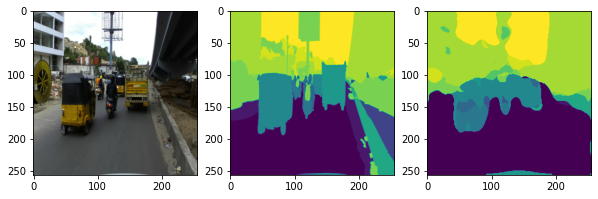

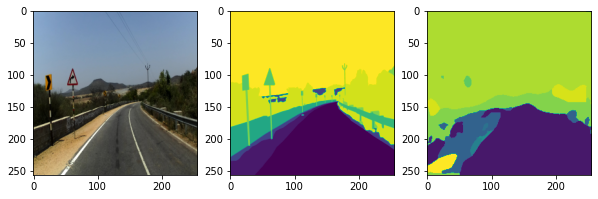

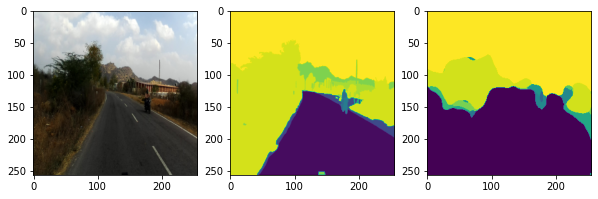

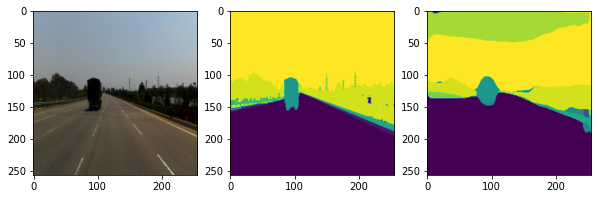

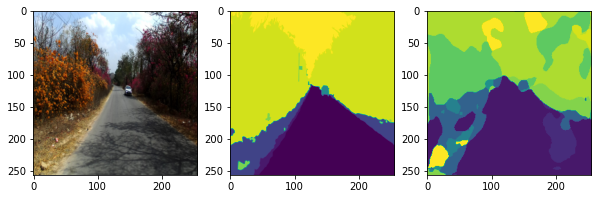

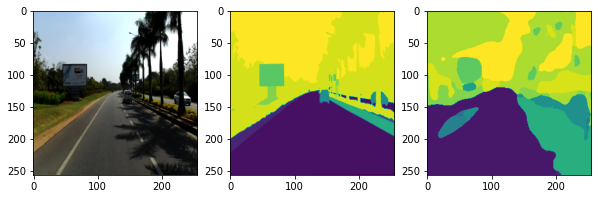

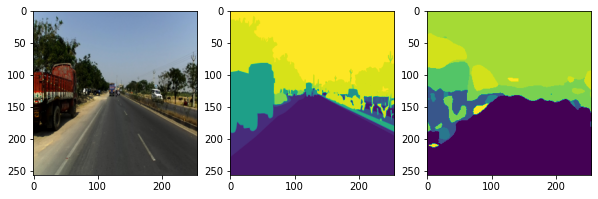

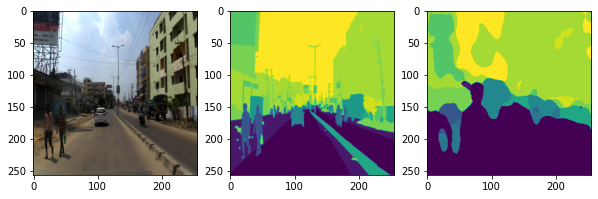

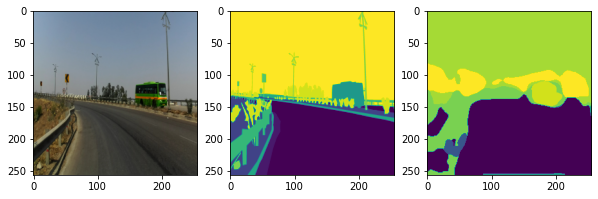

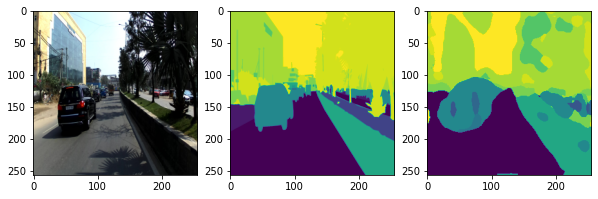

In [87]:
predict(model)

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations